### Imports

In [1]:
import os
import sys

sys.path.append(os.path.abspath('../'))

from data import get_mri_dataloader
from mri import MRI
from nn import NeuralNet, FourierFeatureMapping
from utils import get_device


%load_ext autoreload
%autoreload 2

### Data

In [2]:
# Load the MRI data from the file
file_path = '../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_8.nii.gz'
mri = MRI(file_path)

08:47:46 | Reading data from ../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_8.nii.gz


08:47:46 | Displaying relevant brain slices


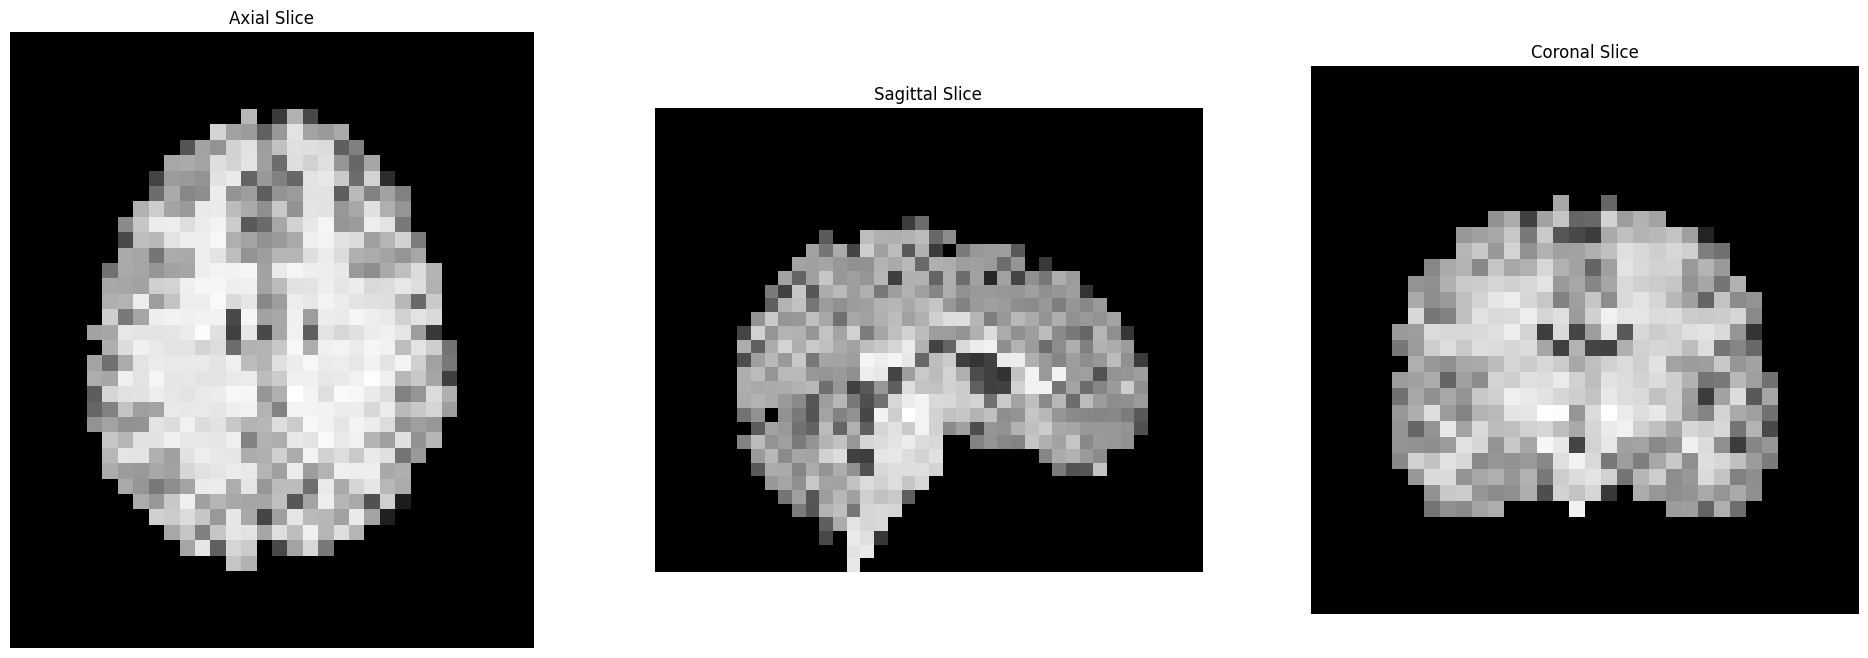

In [3]:
mri.display_relevant_brain_slices()

In [4]:
print(f"Voxel grid size: {mri.data.shape}")
print(f"Total number of points in MRI: {mri.data.flatten().shape[0]}")

Voxel grid size: (34, 40, 34)
Total number of points in MRI: 46240


In [5]:
device = get_device()
dataloader = get_mri_dataloader(mri, batch_size=2048, device=device)

08:47:46 | Create voxel grid from MRI


------------------------------------------------------------
NVIDIA GeForce RTX 3050 Ti Laptop GPU
Memory Usage:
	Allocated: 0.0 GB
	Reserved:  0.0 GB
------------------------------------------------------------


08:47:47 | Get intensity values from MRI
08:47:47 | Creating the dataloader


In [72]:
import torch.nn as nn
import torch.optim as optim

# Assuming net is your model and dataloader is your data loader
net = NeuralNet(192).to(device)
fourier_mapping = FourierFeatureMapping(32, scale=10, device=device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)  # Adjust learning rate as needed

# Loss function
mse_loss = nn.MSELoss()

# Number of epochs - one epoch means the model has seen all the data once
num_epochs = 500  # Adjust as needed

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # Get the input features and target labels, and put them on the device
        coords, gt_intensity_values = data
        coords, gt_intensity_values = coords.to(device), gt_intensity_values.to(device)
        coords = fourier_mapping.positional_encoding(coords)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        pred_intensity_values = net(coords)

        # Compute loss
        loss = mse_loss(pred_intensity_values.squeeze(), gt_intensity_values)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / 100:.3f}')
    running_loss = 0.0

print('Finished Training')


[1] loss: 20403.498
[2] loss: 20163.796
[3] loss: 20073.426
[4] loss: 20041.893
[5] loss: 19950.701
[6] loss: 19907.968
[7] loss: 19869.987
[8] loss: 19856.831
[9] loss: 19787.023
[10] loss: 19738.751
[11] loss: 19667.914
[12] loss: 19663.855
[13] loss: 19609.239
[14] loss: 19596.076
[15] loss: 19545.910
[16] loss: 19492.020
[17] loss: 19471.044
[18] loss: 19415.858
[19] loss: 19410.213
[20] loss: 19316.745
[21] loss: 19231.584
[22] loss: 19228.376
[23] loss: 19138.564
[24] loss: 19101.256
[25] loss: 19081.254
[26] loss: 19000.709
[27] loss: 18973.150
[28] loss: 18919.438
[29] loss: 18888.659
[30] loss: 18840.971
[31] loss: 18775.787
[32] loss: 18671.989
[33] loss: 18667.358
[34] loss: 18613.969
[35] loss: 18520.154
[36] loss: 18512.122
[37] loss: 18454.765
[38] loss: 18348.840
[39] loss: 18329.849
[40] loss: 18241.716
[41] loss: 18191.481
[42] loss: 18167.171
[43] loss: 18081.132
[44] loss: 18078.055
[45] loss: 17986.046
[46] loss: 17847.811
[47] loss: 17865.907
[48] loss: 17775.957
[

In [73]:
from data import get_test_dataloader
import torch

upsample_factor = 4
voxel_loader = get_test_dataloader(mri, upsample_factor, 2048, device)

# Set the network to evaluation mode
net.eval()

# Store predictions for each batch
batch_predictions = []

# Disable gradient calculations
with torch.no_grad():
    for batch in voxel_loader:
        # Move batch to device
        coords = batch.to(device)
        coords = fourier_mapping.positional_encoding(coords)

        # Predict intensity values for the batch
        batch_pred = net(coords)

        # Move predictions to CPU and store
        batch_predictions.append(batch_pred.cpu())

# Concatenate all batch predictions
all_predictions = torch.cat(batch_predictions, dim=0)

# Convert to numpy array
predicted_intensities_np = all_predictions.squeeze().numpy()

# Reshape the array to the desired MRI dimensions
x_dim, y_dim, z_dim = [ax * upsample_factor for ax in mri.data.shape]
predicted_mri = predicted_intensities_np.reshape((x_dim, y_dim, z_dim))

10:53:44 | Create voxel grid from MRI


(-0.5, 135.5, -0.5, 135.5)

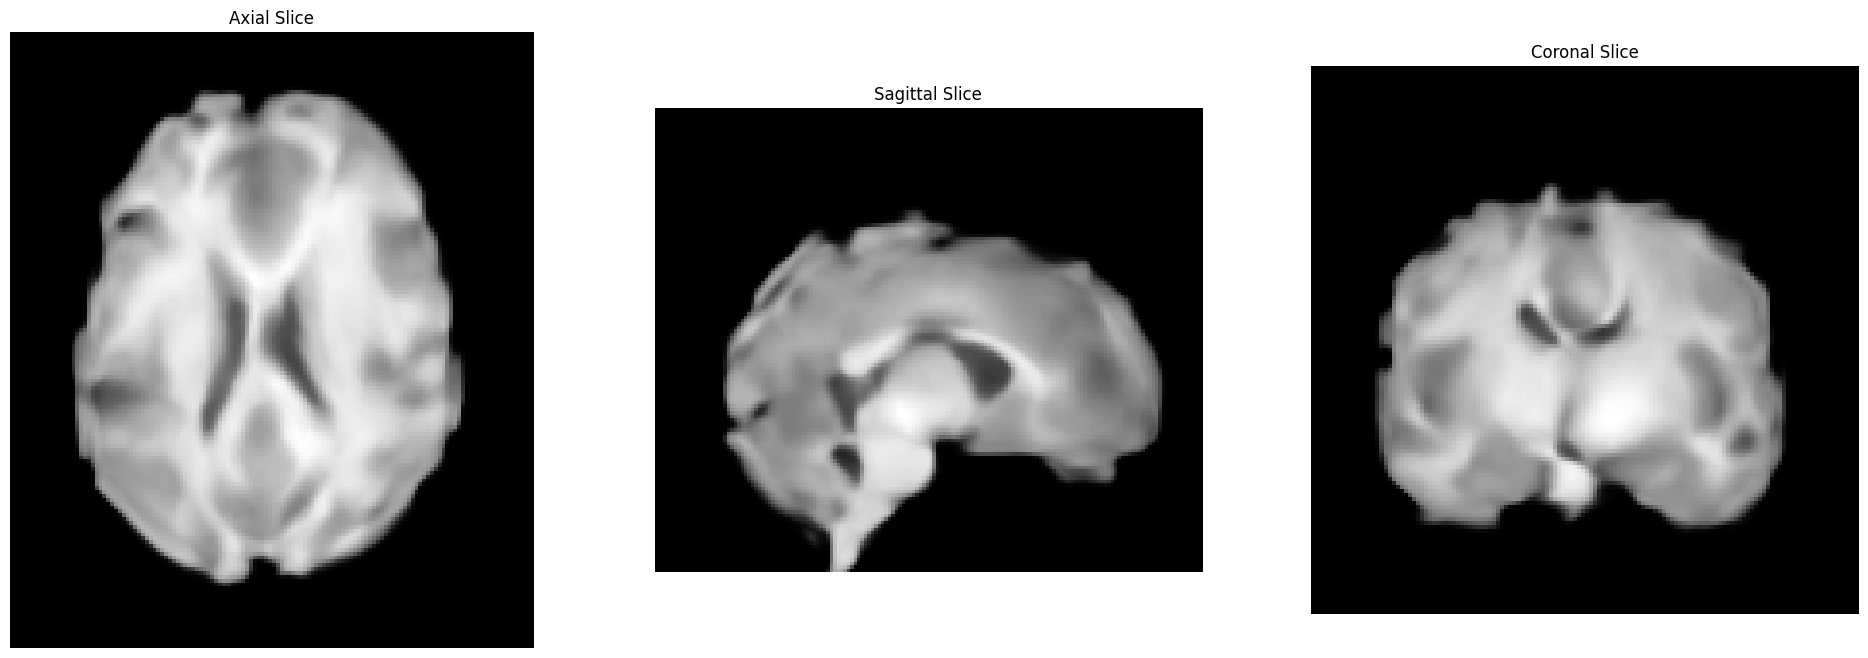

In [74]:
import matplotlib.pyplot as plt


# Select an axial slice - middle of the brain
sagittal_slice = predicted_mri[predicted_mri.shape[0] // 2, :, :]
coronal_slice = predicted_mri[:, predicted_mri.shape[1] // 2, :]
axial_slice = predicted_mri[:, :, predicted_mri.shape[2] // 2]

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Display each slice
axes[0].imshow(axial_slice.T, cmap="gray", origin="lower")
axes[0].set_title("Axial Slice")
axes[0].axis("off")

axes[1].imshow(sagittal_slice.T, cmap="gray", origin="lower")
axes[1].set_title("Sagittal Slice")
axes[1].axis("off")

axes[2].imshow(coronal_slice.T, cmap="gray", origin="lower")
axes[2].set_title("Coronal Slice")
axes[2].axis("off")

In [75]:
fourier_mapping.gaussian(torch.tensor([0, 1, 2]).to(device))

tensor([ 0.2416, -0.7301,  0.6753,  0.3402,  0.7312,  0.1896,  0.4764, -0.9869,
         0.0934,  0.8881,  0.0509,  0.4754, -0.5025, -0.2615,  0.8708, -0.3873,
        -0.6213,  0.4704, -0.9259, -0.8326,  0.3614,  0.0476, -0.5530, -0.9249,
        -0.0161,  0.5619, -0.9280,  0.7627,  0.1349,  0.1576,  0.9995,  0.5112,
        -0.9704,  0.6834, -0.7375, -0.9403, -0.6822, -0.9819, -0.8792, -0.1611,
        -0.9956,  0.4596,  0.9987,  0.8798,  0.8646,  0.9652, -0.4916,  0.9219,
         0.7836, -0.8825, -0.3779,  0.5538, -0.9324,  0.9989, -0.8332,  0.3802,
         0.9999, -0.8272,  0.3726,  0.6467,  0.9909,  0.9875,  0.0324, -0.8594],
       device='cuda:0')